### Load Packages

In [57]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
sys.path.append('../')

In [58]:
"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Generate seating plan given a room, number of students, proportion of students vaccinated
"""
def generate_seating_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    grid = room.copy()
    grid = grid.reset_index()
    grid['seating'] = 'E'

    gridunvax = grid[grid['UnvaxSpot'] == 1]
    unvax_seats = list(gridunvax['index'].sample(Nunvax).values)
    grid['seating'].loc[grid['index'].isin(unvax_seats)] = 'U'
    
    vax_seats = random.sample(Diff(list(grid['index'].values),unvax_seats),Nvax)
    grid['seating'].loc[grid['index'].isin(vax_seats)] = 'V'
    
    return grid

""" generate random seating plan
room argument is irrelevant
"""
def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time): 
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const = 1
    if susceptible_status == 'V':
        susceptible_const = 0.25
    if source_status == 'V':
        source_const = 0.25
    if masked_status == True:
        masked_const = 0.8

    prob = susceptible_const*(1-np.exp(-1 * source_const* masked_const * 0.0135 * 2.1 * (-0.1819*np.log(d)+0.43276)/d))
    prob = float(prob)
    return max(prob,0)


"""
vax_infected = 1 if source is vaccinated
vax_infected = 0 if source is unvaccinated

"""
def simulate_class_single(room,vax_infected, unvax_infected, time, function,alpha,masked_status):
    
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]

    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    
    infected_x = infected['x']
    infected_y = infected['y']
    #plt.scatter(infected_x,infected_y, color = 'red')

    p_infections = []
    for i,row in uninfected.iterrows():
        x = row['x']
        y = row['y']
        
        v_infect = [x-infected_x,y - infected_y]
        v_vert = [0,10000]
    
        dot = v_infect[1]*v_vert[1]
        mag1 = 10000
        mag2 = np.sqrt((x-infected_x)**2+(y - infected_y)**2)
        
        theta =  math.acos(dot/(mag1*mag2))*180/math.pi
        
        if theta < 90 + alpha:
            #plt.scatter(x,y, color = 'orange')
            susceptible_status = row['seating']
            dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
            p = function(dist,susceptible_status,source_status,masked_status,1)
            p_infections.append(p)
        
        #else:
            #plt.scatter(x,y, color = 'grey')
            
    
    return np.sum(p_infections)


"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0

# Room Configurations

Text(0.5, 1.0, 'Olin 155')

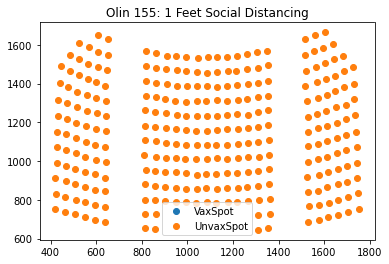

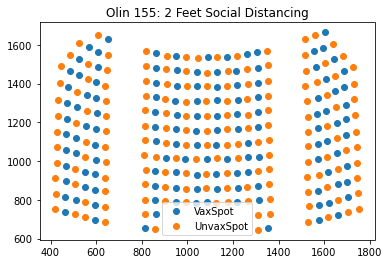

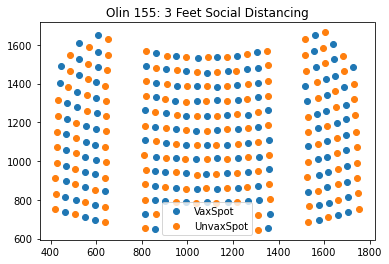

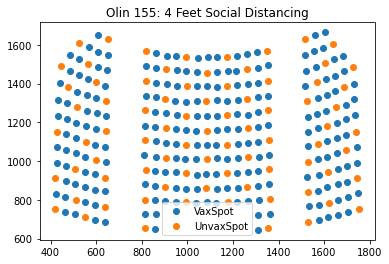

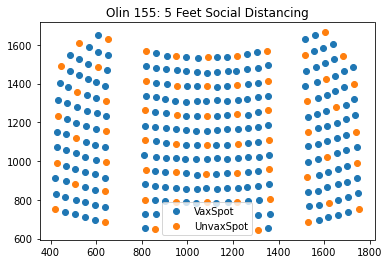

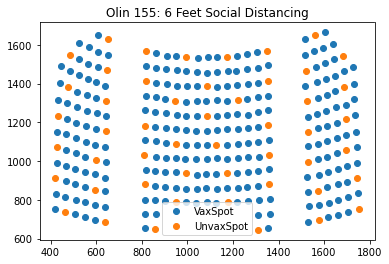

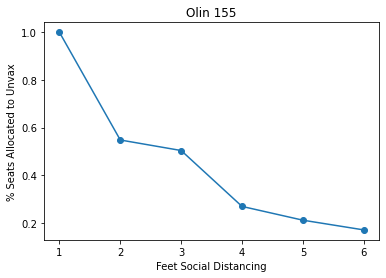

In [59]:
with open("../Data/olin155_1foot.pickle" , 'rb') as handle:
    results_1feet = pickle.load(handle)

with open("../Data/olin155_2foot.pickle" , 'rb') as handle:
    results_2feet = pickle.load(handle)

with open("../Data/olin155_3foot.pickle" , 'rb') as handle:
    results_3feet = pickle.load(handle)

with open("../Data/olin155_4foot.pickle" , 'rb') as handle:
    results_4feet = pickle.load(handle)

with open("../Data/olin155_5foot.pickle" , 'rb') as handle:
    results_5feet = pickle.load(handle)

with open("../Data/olin155_6foot.pickle" , 'rb') as handle:
    results_6feet = pickle.load(handle)
    
pixels_per_foot = (1963-1460)/20
total_seats = 294

layouts = [results_1feet,results_2feet,results_3feet,results_4feet,results_5feet,results_6feet]
feets = [1,2,3,4,5,6]

rooms = []
unvax_prop = []
i = 0
for layout in layouts:
    ft = feets[i]
    x_coord = [i.x for i in layout['Middles']]
    y_coord = [i.y for i in layout['Middles']]
    room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
    room['UnvaxSpot'] = layout['In Solution']
    room['feet_apart'] = ft
    unvax_prop.append(sum(room['UnvaxSpot'])/len(room))
    rooms.append(room)
    plt.figure()
    plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'], label = 'VaxSpot')
    plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], label = 'UnvaxSpot')
    plt.title('Olin 155: ' + str(ft) + ' Feet Social Distancing')
    plt.legend()
    i = i + 1 


    
    

    
plt.figure()
plt.scatter(feets,unvax_prop)
plt.plot(feets,unvax_prop)
plt.xlabel('Feet Social Distancing')
plt.ylabel('% Seats Allocated to Unvax')
plt.title('Olin 155')




# Random Configuration

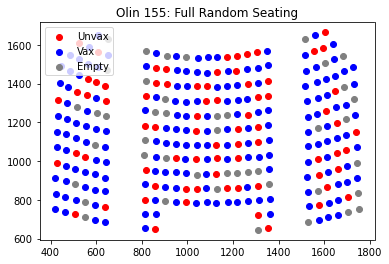

In [62]:
rand = generate_random_plan(250,.7,rooms[0])
plt.figure()
plt.scatter(rand[rand['seating'] == 'U']['x'],rand[rand['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(rand[rand['seating'] == 'V']['x'],rand[rand['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(rand[rand['seating'] == 'E']['x'],rand[rand['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Olin 155: '+ 'Full Random Seating')
plt.legend()

# Distanced Seating Plans

In [ ]:
N_range = np.arange(36,294,12)
p_range = np.arange(0,1.1,.1)
room_list =  rooms
results = []

for N in N_range:
    for p in p_range:
        print(N,p)
        for room in room_list:
            gc.collect()
            try:
                trial = 0
                while trial < 100:
                    grid = generate_seating_plan(N,p,room)
                    p_generate = p /(4-3*p)
                    ind = flip(p_generate)
                    
                    if sum(room['UnvaxSpot']) == len(room):
                        ind = 0    
                    elif sum(grid['seating'] == 'V') == 0:
                        ind = 0
                    elif sum(grid['seating'] == 'U') == 0:
                        ind = 1
                    infect = simulate_class_single(grid,ind, 1-ind, 1, updated_distance_to_prob,15,False)
                    number_unvax = sum(grid['seating']=='U')
                    results.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind, np.mean(room['feet_apart'])])
                    trial = trial+ 1
            except:
                print('error')
            
results = pd.DataFrame(results,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind','feet_apart'])

36 0.0
36 0.1
36 0.2
36 0.30000000000000004
36 0.4
36 0.5
36 0.6000000000000001
36 0.7000000000000001
36 0.8
36 0.9
36 1.0
error
48 0.0
48 0.1
48 0.2
48 0.30000000000000004
48 0.4
48 0.5
48 0.6000000000000001
48 0.7000000000000001
48 0.8
48 0.9
48 1.0
error
60 0.0
error
60 0.1
error
60 0.2
60 0.30000000000000004
60 0.4
60 0.5
60 0.6000000000000001
60 0.7000000000000001
60 0.8
60 0.9
60 1.0
error
72 0.0
error
error
72 0.1
error
error
72 0.2
error
72 0.30000000000000004
72 0.4
72 0.5
72 0.6000000000000001
72 0.7000000000000001
72 0.8
72 0.9
72 1.0
error
84 0.0
error
error
error
84 0.1
error
error
84 0.2
error
error
84 0.30000000000000004
error
84 0.4
84 0.5
84 0.6000000000000001
84 0.7000000000000001
84 0.8
84 0.9
84 1.0
error
96 0.0
error
error
error
96 0.1
error
error
error
96 0.2
error
error
96 0.30000000000000004
error
error
96 0.4
error
96 0.5
96 0.6000000000000001
96 0.7000000000000001
96 0.8
96 0.9
96 1.0
error
108 0.0
error
error
error
108 0.1
error
error
error
108 0.2
error
erro

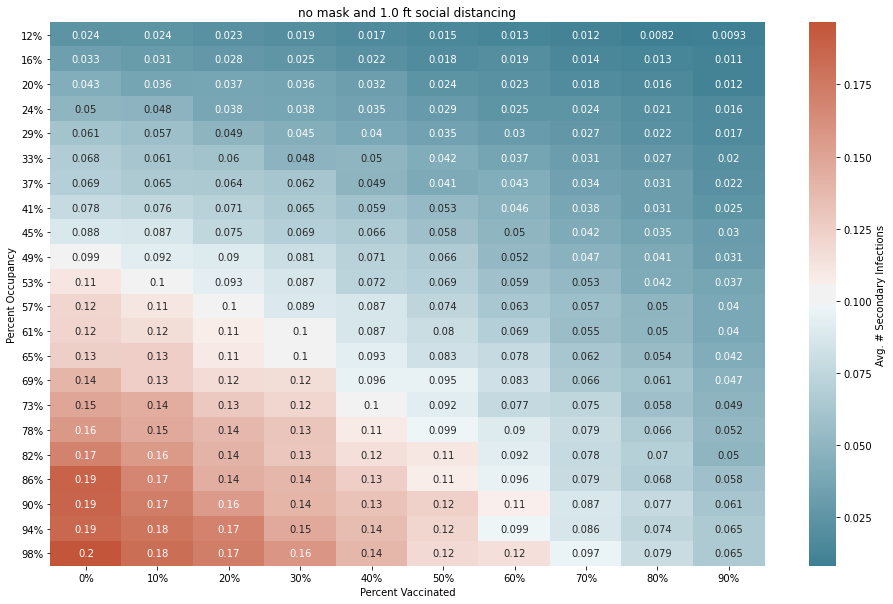

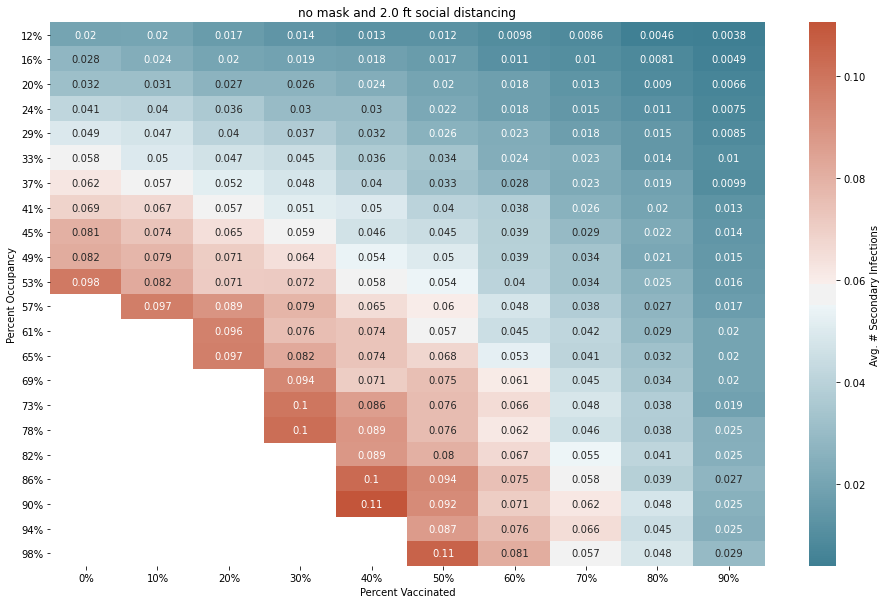

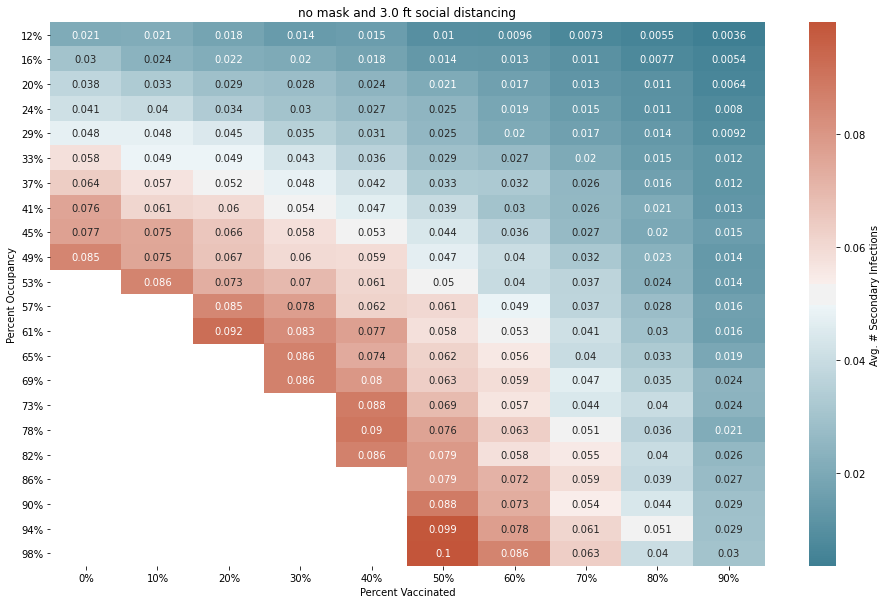

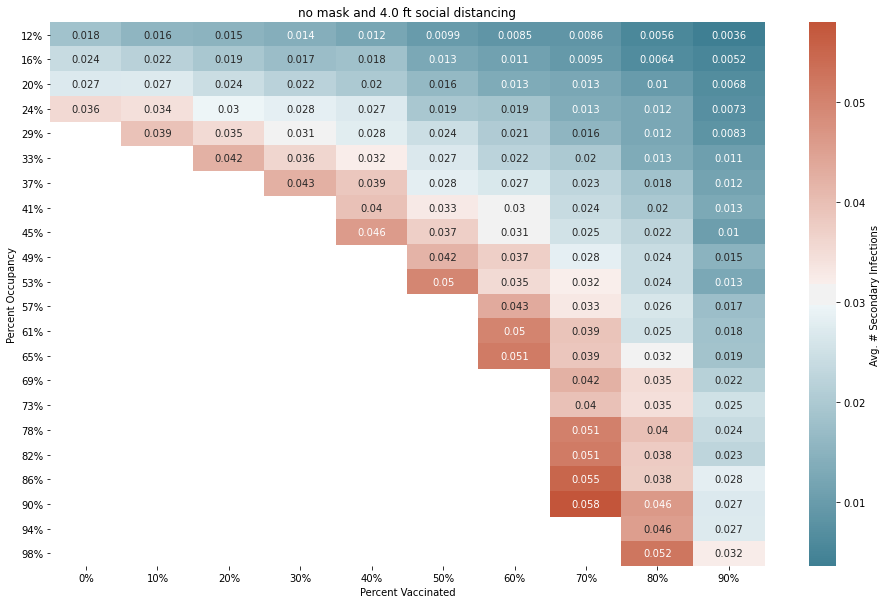

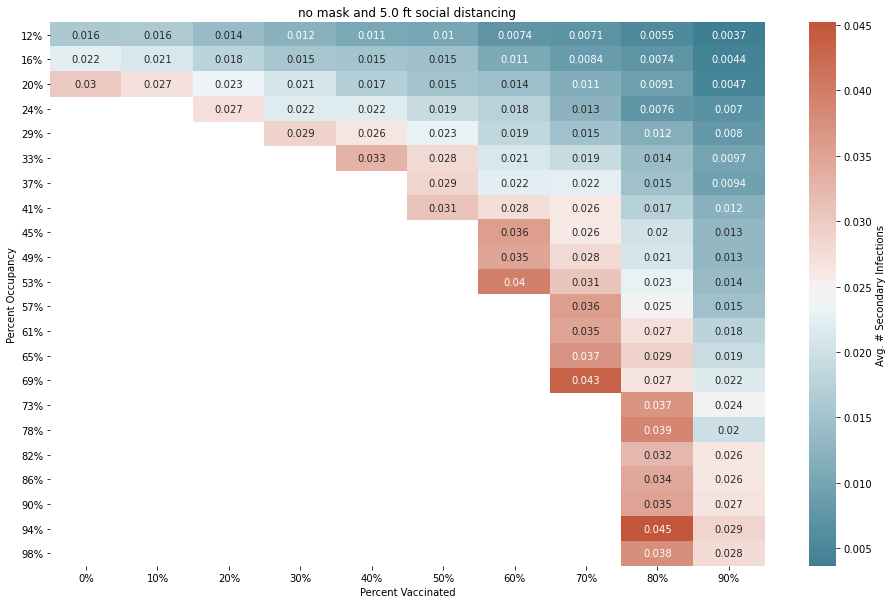

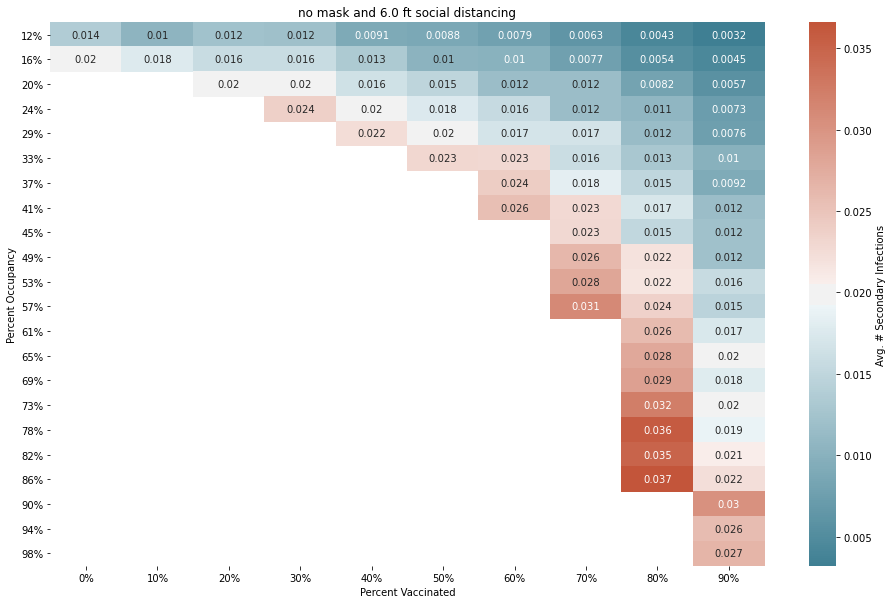

In [98]:
#results['p_max']= [Fall2020_risk/x for x in results['infected'].values]
import matplotlib.ticker as mtick
results['Percent Occupancy'] = results['N']/total_seats
results['Percent Vaccinated'] = results['p']
cmap = sns.diverging_palette(220, 20, as_cmap=True)
to_plot = results.copy()

for feet_apart in np.unique(to_plot['feet_apart'].values):
    plt.figure(figsize=(16,10))
    p1 = to_plot[to_plot['feet_apart'] == feet_apart]
    p1 = p1[p1['Percent Vaccinated'] < 1]

    agg_results = p1.groupby(['Percent Occupancy','Percent Vaccinated']).infected.mean().reset_index()
    agg_results['Percent Occupancy'] = round(agg_results['Percent Occupancy'],2)
    agg_results['Percent Vaccinated'] = round(agg_results['Percent Vaccinated'],2)
    
    
    ax = sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','infected'), cmap=cmap, annot = True,cbar_kws={'label': 'Avg. # Secondary Infections'})
    labels = [item.get_text()[-1]+'0%' for item in ax.get_xticklabels()]
    labels[0] = '0%'
    ax.set_xticklabels(labels)
    
    labels = [item.get_text()[-2:]+'%' for item in ax.get_yticklabels()]
    labels[-3] = '90%'
    labels[2] = '20%'
    ax.set_yticklabels(labels)
    
    plt.yticks(rotation=360)
    plt.title('no mask and ' + str(feet_apart) + ' ft social distancing')
  

In [103]:
agg_results['Percent Occupancy'] = round(agg_results['Percent Occupancy'],2)
agg_results['Percent Vaccinated'] = round(agg_results['Percent Vaccinated'],2)

In [104]:
agg_results

,Percent Occupancy,Percent Vaccinated,infected
0,0.12,0.0,0.013646
1,0.12,0.1,0.010475
2,0.12,0.2,0.012300
3,0.12,0.3,0.011952
4,0.12,0.4,0.009068
...,...,...,...
78,0.86,0.8,0.036596
79,0.86,0.9,0.022296
80,0.90,0.9,0.030230
81,0.94,0.9,0.025784


In [105]:
results

,N,p,infected,number_unvax,number_unvax_seats,ind,feet_apart,Percent Occupancy,Percent Vaccinated
0,36,0.0,0.023305,36,294.0,0,1.0,0.122449,0.0
1,36,0.0,0.047564,36,294.0,0,1.0,0.122449,0.0
2,36,0.0,0.014243,36,294.0,0,1.0,0.122449,0.0
3,36,0.0,0.014175,36,294.0,0,1.0,0.122449,0.0
4,36,0.0,0.019033,36,294.0,0,1.0,0.122449,0.0
...,...,...,...,...,...,...,...,...,...
99295,288,1.0,0.012361,0,50.0,1,6.0,0.979592,1.0
99296,288,1.0,0.014064,0,50.0,1,6.0,0.979592,1.0
99297,288,1.0,0.007799,0,50.0,1,6.0,0.979592,1.0
99298,288,1.0,0.006106,0,50.0,1,6.0,0.979592,1.0


In [106]:
results.to_csv('updated_function_nomasks_distanced.csv')

# Random Seating

In [14]:
N_range = np.arange(36,294,12)
p_range = np.arange(0,1.1,.1)
room_list =  rooms
results_rand = []

for N in N_range:
    for p in p_range:
        print(N,p)
        room = rooms[0]
        trial = 0
        while trial < 50:
            grid = generate_random_plan(N,p,room)
            prop_vax = p
                    
            p_generate = prop_vax /(4-3*prop_vax)
            ind = flip(p_generate)
            if sum(grid['seating'] == 'V') == 0:
                ind = 0
            elif sum(grid['seating'] == 'U') == 0:
                ind = 1
            infect = simulate_class_single(grid,ind, 1-ind, 1, updated_distance_to_prob,15,True)
            number_unvax = sum(grid['seating']=='U')
            results_rand.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind, np.mean(room['feet_apart'])])
            trial = trial+ 1
                

36 0.0
36 0.1
36 0.2
36 0.30000000000000004
36 0.4
36 0.5
36 0.6000000000000001
36 0.7000000000000001
36 0.8
36 0.9
36 1.0
48 0.0
48 0.1
48 0.2
48 0.30000000000000004
48 0.4
48 0.5
48 0.6000000000000001
48 0.7000000000000001
48 0.8
48 0.9
48 1.0
60 0.0
60 0.1
60 0.2
60 0.30000000000000004
60 0.4
60 0.5
60 0.6000000000000001
60 0.7000000000000001
60 0.8
60 0.9
60 1.0
72 0.0
72 0.1
72 0.2
72 0.30000000000000004
72 0.4
72 0.5
72 0.6000000000000001
72 0.7000000000000001
72 0.8
72 0.9
72 1.0
84 0.0
84 0.1
84 0.2
84 0.30000000000000004
84 0.4
84 0.5
84 0.6000000000000001
84 0.7000000000000001
84 0.8
84 0.9
84 1.0
96 0.0
96 0.1
96 0.2
96 0.30000000000000004
96 0.4
96 0.5
96 0.6000000000000001
96 0.7000000000000001
96 0.8
96 0.9
96 1.0
108 0.0
108 0.1
108 0.2
108 0.30000000000000004
108 0.4
108 0.5
108 0.6000000000000001
108 0.7000000000000001
108 0.8
108 0.9
108 1.0
120 0.0
120 0.1
120 0.2
120 0.30000000000000004
120 0.4
120 0.5
120 0.6000000000000001
120 0.7000000000000001
120 0.8
120 0.9
12

In [11]:
results_rand = pd.DataFrame(results_rand,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind','feet_apart'])

In [11]:
plt.figure(figsize = (16,10))
results_rand['Percent Occupancy'] = results_rand['N']/total_seats
results_rand['Percent Vaccinated'] = results_rand['p']
cmap = sns.diverging_palette(220, 20, as_cmap=True)
agg_results = results_rand.groupby(['Percent Occupancy','Percent Vaccinated']).infected.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','infected'), cmap=cmap, annot = True,fmt='.2f')
plt.title('Random Seating Masked')

NameError: name 'results_rand' is not defined

<Figure size 1152x720 with 0 Axes>

In [13]:
results_rand.to_csv('updated_function_masks_random.csv')